In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import missingno as msno 
from geopy.geocoders import Nominatim
import seaborn as sns

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [75]:
import statsmodels.api as sm
from sklearn import tree
import pydotplus

In [4]:
df_clean = pd.read_csv('data/df_clean.csv')
df_clean.head()

,status,card_present_flag,bpay_biller_code,account,currency,txn_description,merchant_id,first_name,balance,date,...,transaction_id,country,customer_id,movement,customer_long,customer_lat,merchant_long,merchant_lat,customer_state,age_group
0,authorized,1.0,NaN,ACC-1598451071,AUD,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01 00:00:00,...,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,debit,153.41,-27.95,153.38,-27.99,Queensland,21-30
1,authorized,0.0,NaN,ACC-1598451071,AUD,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01 00:00:00,...,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,debit,153.41,-27.95,151.21,-33.87,Queensland,21-30
2,authorized,1.0,NaN,ACC-1222300524,AUD,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael_1,5.71,2018-08-01 00:00:00,...,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,debit,151.23,-33.94,151.21,-33.87,New South Wales,31-40
3,authorized,1.0,NaN,ACC-1037050564,AUD,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.22,2018-08-01 00:00:00,...,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,debit,153.10,-27.66,153.05,-26.68,Queensland,31-40
4,authorized,1.0,NaN,ACC-1598451071,AUD,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,17.95,2018-08-01 00:00:00,...,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,debit,153.41,-27.95,153.44,-28.06,Queensland,21-30


## Predictive Analytics
Explore correlations between customer attributes, build a regression and a decision-tree prediction model based on your findings.



Using the same transaction dataset, identify the annual salary for each customer

Explore correlations between annual salary and various customer attributes (e.g. age). These attributes could be those that are readily available in the data (e.g. age) or those that you construct or derive yourself (e.g. those relating to purchasing behaviour). Visualise any interesting correlations using a scatter plot.

Build a simple regression model to predict the annual salary for each customer using the attributes you identified above

How accurate is your model? Should ANZ use it to segment customers (for whom it does not have this data) into income brackets for reporting purposes?

For a challenge: build a decision-tree based model to predict salary. Does it perform better? How would you accurately test the performance of this model?


- Data Wrangling
- Linear Regressino
- Tree Regression

### Identify the annual salary for each customer



In [22]:
customer = df_clean.customer_id.unique()
salary_interval = []
date_interval = []
for i in customer:
    temp = df_clean[(df_clean.customer_id == i) & (df_clean.txn_description == 'PAY/SALARY')][['amount', 'date']]
    temp['date'] = pd.to_datetime(temp['date'])
    count = len(temp)
    s = []
    lvl = []
    for j in range(count - 1):
        s.append(temp['date'].iloc[j+1] - temp['date'].iloc[j])
        lvl.append(temp['amount'].iloc[j])
    salary_interval.append(max(lvl))
    date_interval.append(max(s).days)

annual_salary = pd.DataFrame({'customer_id': customer, 'annual_salary': np.rint(np.array(salary_interval)/np.array(date_interval))*365.25})
        
        
    
    




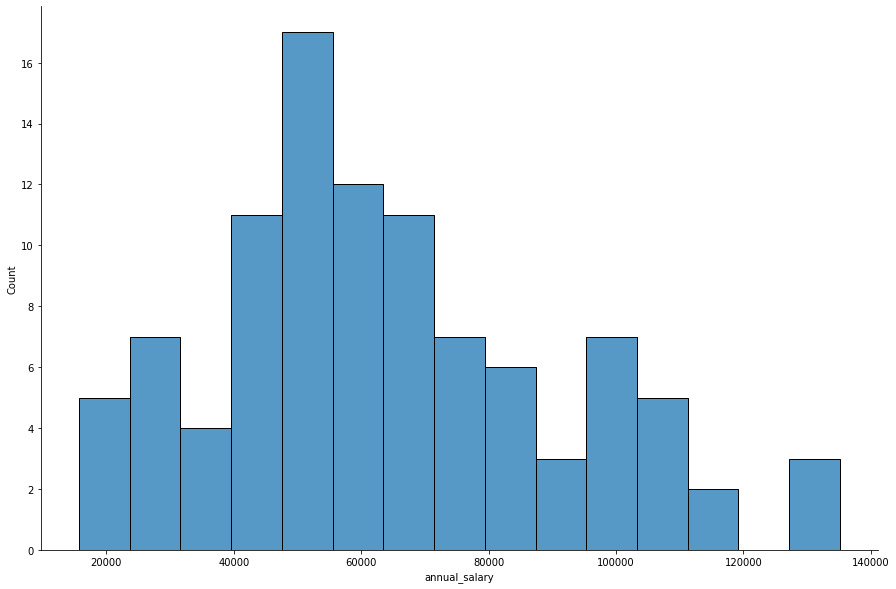

In [23]:
plt.figure(figsize = (15, 10))
sns.histplot(x = 'annual_salary', data = annual_salary, bins = 15)
sns.despine();

In [24]:
# create a dataframe to store relevant features for customers

customer_table = df_clean[['customer_id', 'gender', 'age', 'customer_state']]\
.drop_duplicates()\
.reset_index(drop=True)

#customer = pd.merge(customer, annual_salary, how = 'left', on = 'customer_id')

customer_table.head()


,customer_id,gender,age,customer_state
0,CUS-2487424745,F,26,Queensland
1,CUS-2142601169,M,38,New South Wales
2,CUS-1614226872,F,40,Queensland
3,CUS-2688605418,M,20,New South Wales
4,CUS-4123612273,F,43,Victoria


In [31]:
temp_1 = df_clean.groupby('customer_id').agg({'date': 'nunique', 
                                     'transaction_id': 'count', 
                                     'amount': 'mean', 
                                     'balance': 'mean', 
                                    })
#temp_1.columns = ['_'.join(col) for col in temp_1.columns.values]

temp_1 = temp_1.reset_index()

temp_1.head()

,customer_id,date,transaction_id,amount,balance
0,CUS-1005756958,40,73,222.862603,2275.852055
1,CUS-1117979751,60,100,339.843700,9829.929000
2,CUS-1140341822,42,80,212.632500,5699.212250
3,CUS-1147642491,54,118,245.600169,9032.841186
4,CUS-1196156254,79,245,147.145796,22272.433755


In [32]:
temp_3 = df_clean.groupby(['customer_id', 'txn_description']).size().unstack(fill_value = 0).reset_index()
temp_3.head()


txn_description,customer_id,INTER BANK,PAY/SALARY,PAYMENT,PHONE BANK,POS,SALES-POS
0,CUS-1005756958,0,13,9,3,26,22
1,CUS-1117979751,1,7,40,0,26,26
2,CUS-1140341822,3,6,6,0,39,26
3,CUS-1147642491,2,13,27,0,38,38
4,CUS-1196156254,5,7,70,0,74,89


In [33]:
features = customer_table.merge(temp_1, how = 'left', on = 'customer_id')\
.merge(temp_3, how = 'left', on='customer_id')\
.merge(annual_salary, how = 'left', on='customer_id')

features.drop(['customer_id'], axis = 1)

# age and state
dummy_gender_and_state = pd.get_dummies(features[['gender', 'customer_state']], drop_first = True)

features = features.merge(dummy_gender_and_state, 
               how = 'left',
              left_index = True,
              right_index = True)



features_before_scaled = features\
.drop(['gender', 'customer_state', 'transaction_id', 'customer_id'], 
      axis = 1)


In [34]:
unscaled_features = features_before_scaled.drop(['annual_salary'], axis = 1)
unscaled_targets = features_before_scaled['annual_salary']

/Users/murongcui/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/Users/murongcui/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/Users/murongcui/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/Users/murongcui/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f904cf20390>,
      dtype=object)

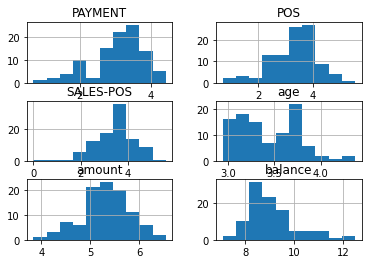

In [59]:
np.log(unscaled_features[['age', 'amount', 'balance', 'PAYMENT',
       'POS', 'SALES-POS']] + 1 ).hist()

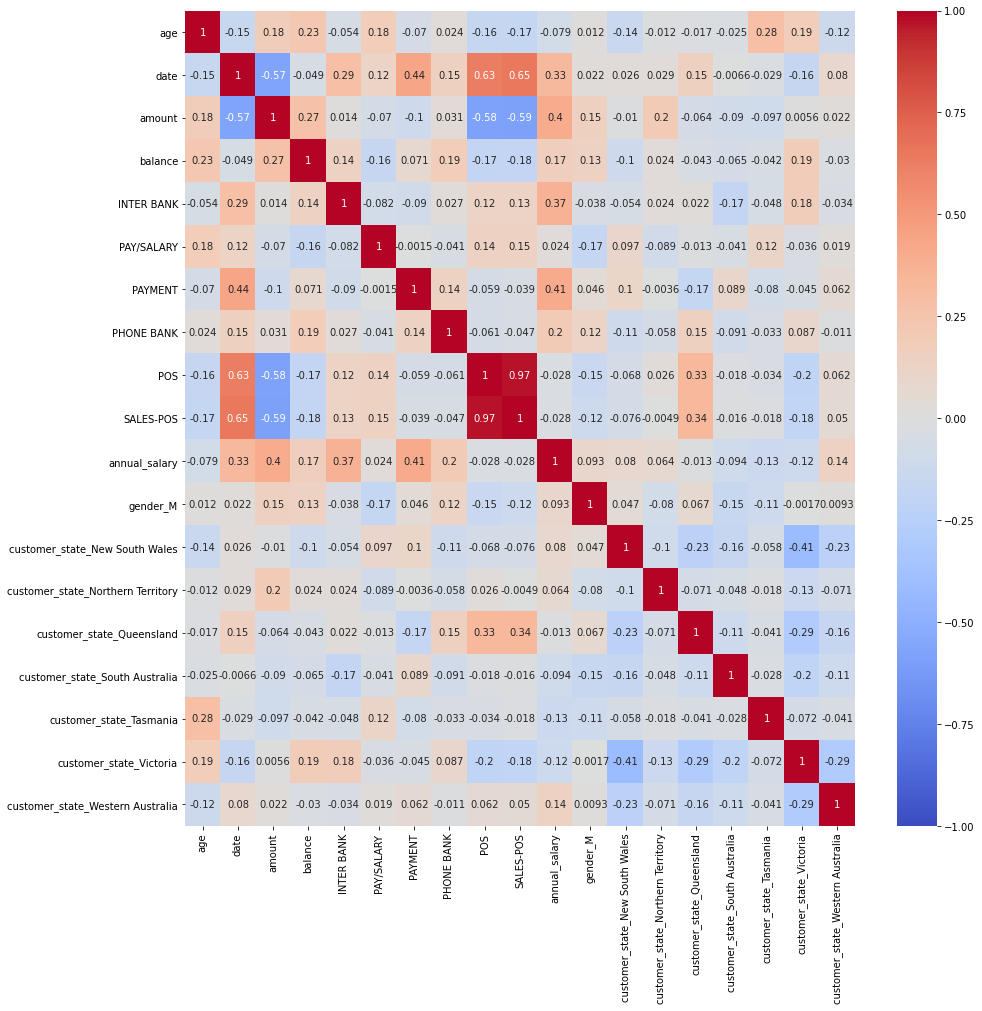

In [35]:
# heatmap correlation
plt.figure(figsize = (15, 15))
sns.heatmap(features_before_scaled.corr(), 
            annot = True, 
            vmin=-1, 
            vmax=1, 
            center= 0, 
            cmap= 'coolwarm');

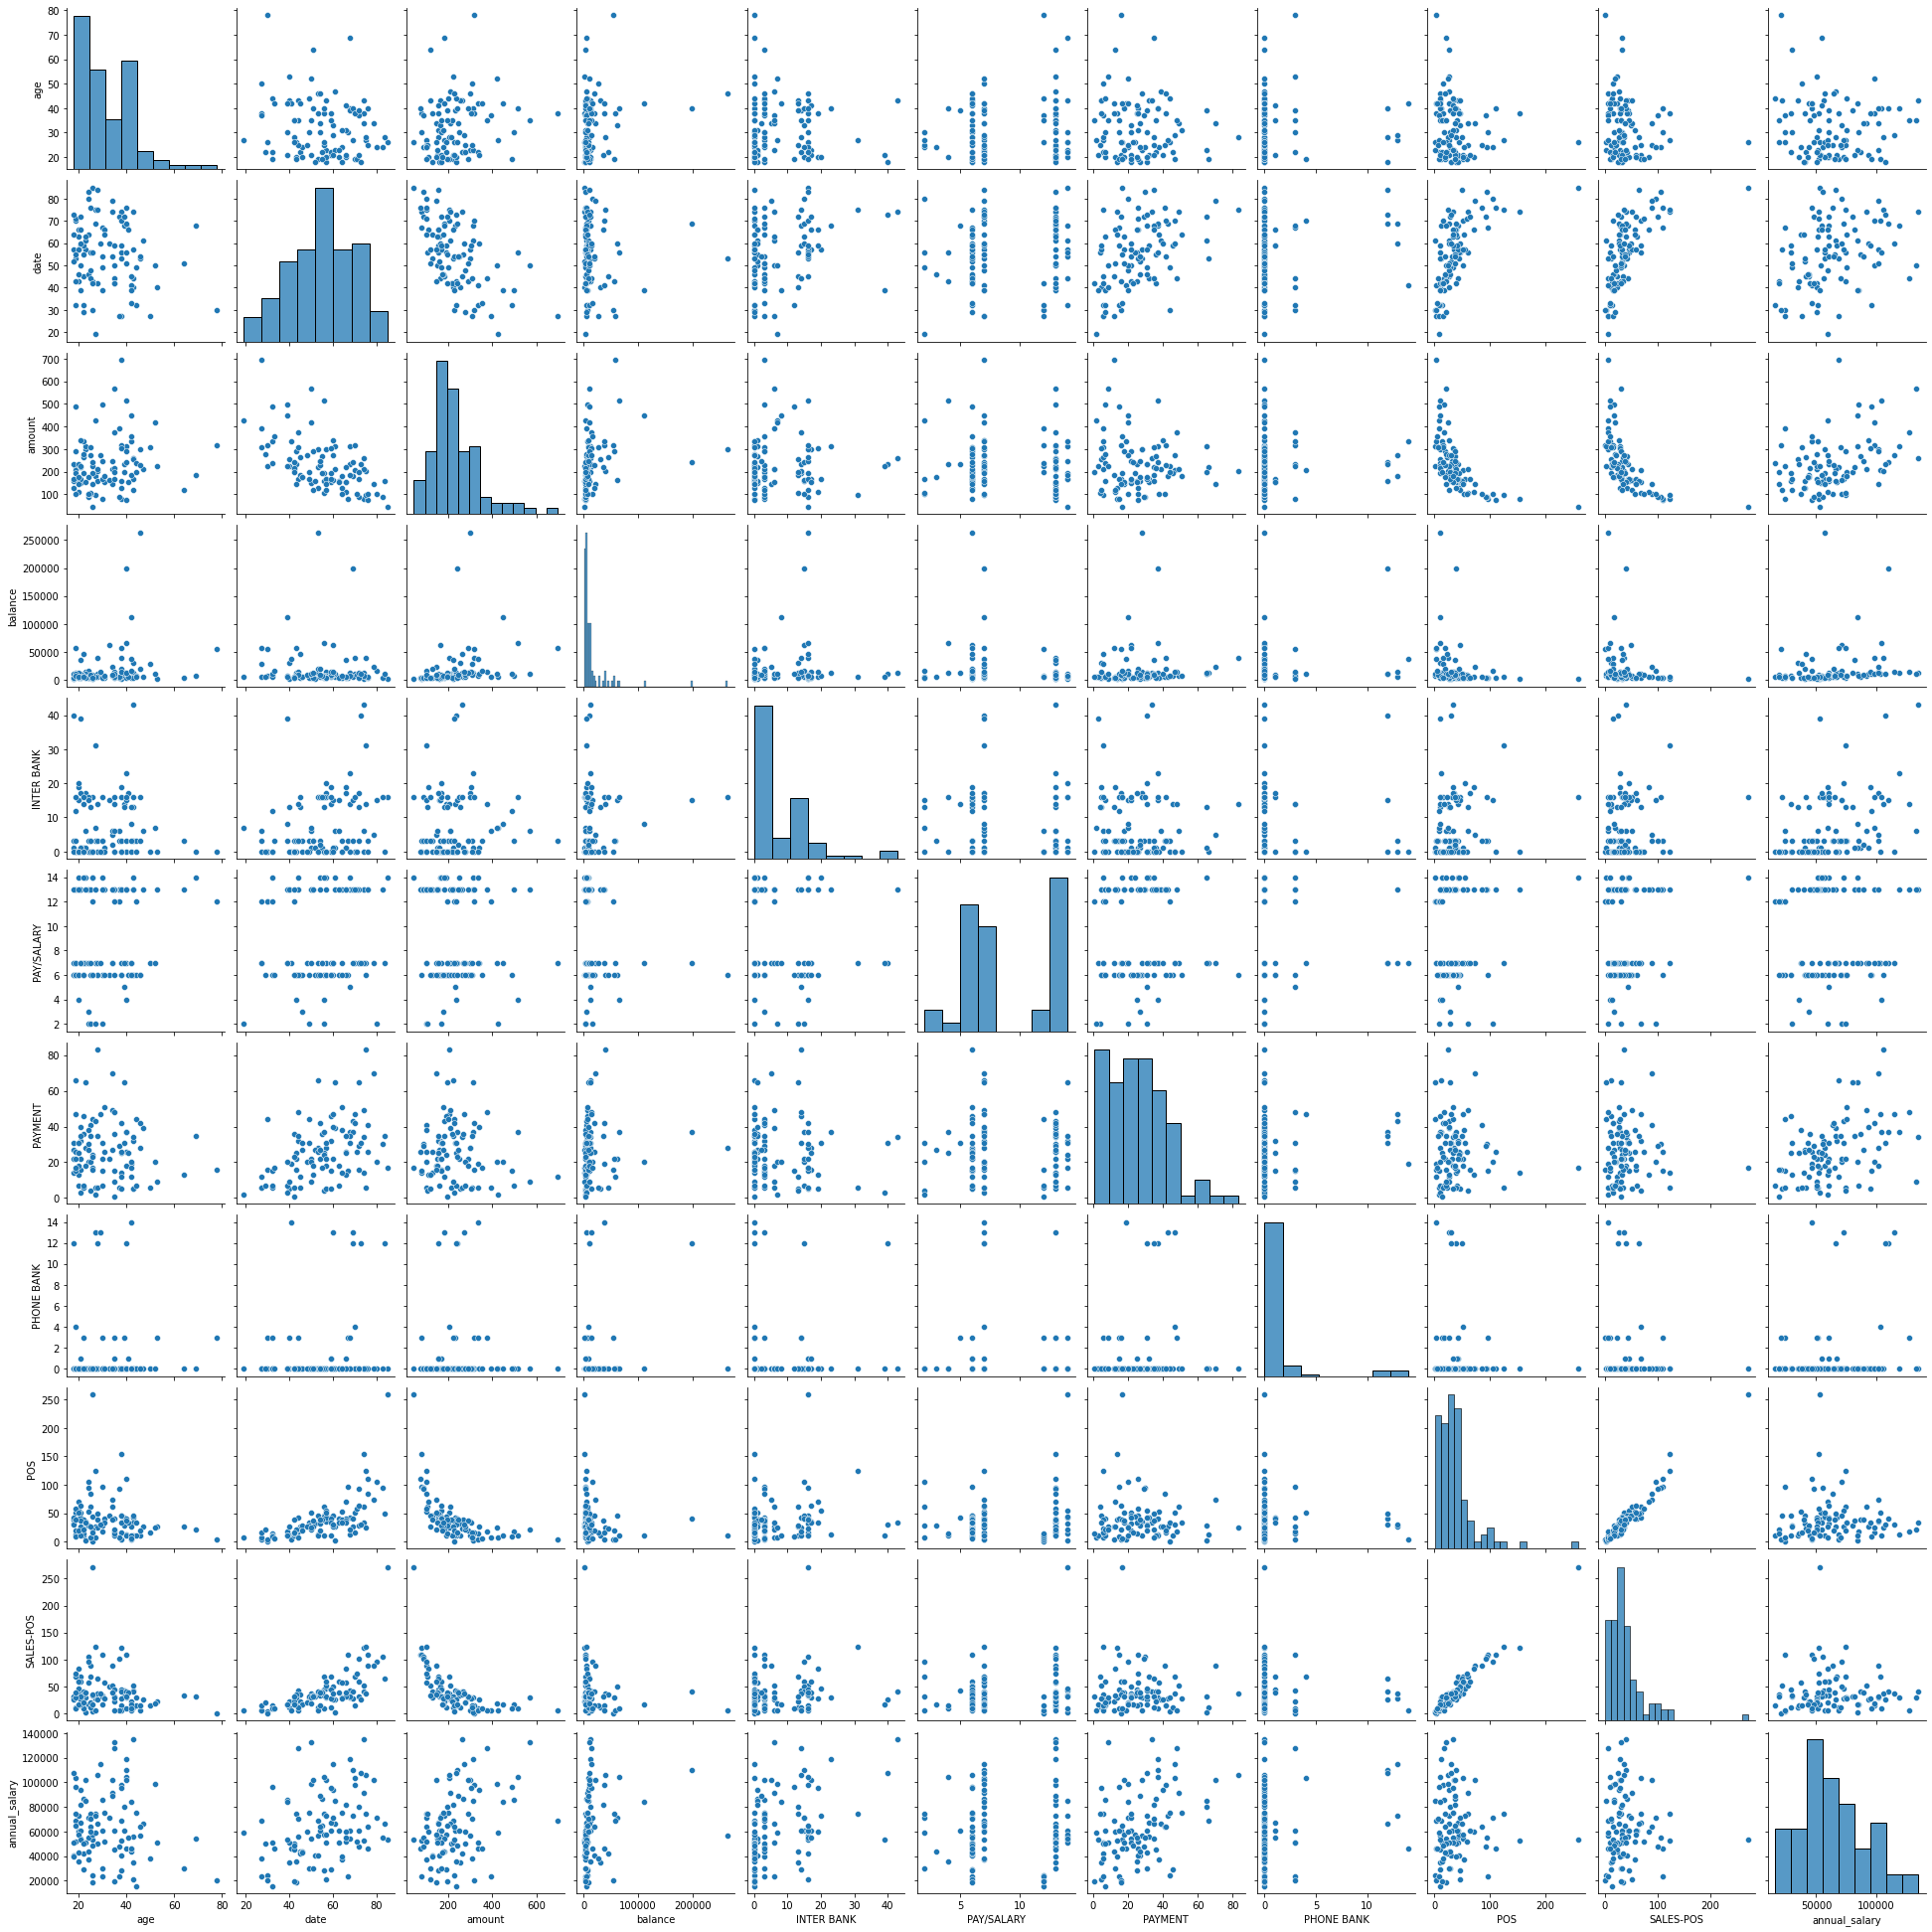

In [38]:
sns.pairplot(features_before_scaled[['age', 'date', 'amount', 'balance',
       'INTER BANK', 'PAY/SALARY', 'PAYMENT', 'PHONE BANK',
       'POS', 'SALES-POS', 'annual_salary']]);

In [39]:
x_train, x_test, y_train, y_test = train_test_split(unscaled_features, 
                                                    unscaled_targets,
                                                   train_size = 0.75,
                                                   random_state = 42)




In [40]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(75, 18) (75,)
(25, 18) (25,)


In [81]:
# Linear Regression
reg = LinearRegression()
reg.fit(x_train, y_train)

print('Coefficients: \n', reg.coef_)
print('Variance scoore: {}'.format(reg.score(x_test, y_test)))

y_predict = reg.predict(x_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

Coefficients: 
 [-3.02559388e+02  9.74889410e+02  2.38865182e+02 -5.03831247e-02
  8.40748344e+02 -1.20070118e+02  5.82145079e+02  6.81689061e+02
  3.68798245e+02 -1.73015216e+02  9.21004934e+02  1.29969189e+03
 -1.82530572e+04 -2.37524994e+03  9.10756908e+03  0.00000000e+00
  8.79873458e+02  2.38898674e+03]
Variance scoore: 0.19377141872307824
21682.55408012313


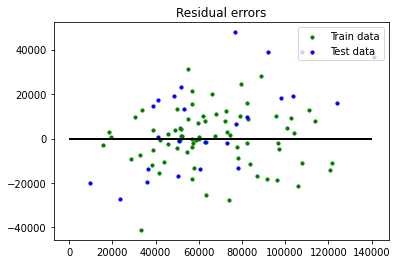

In [51]:
## plotting residual errors in training data 
plt.scatter(reg.predict(x_train), reg.predict(x_train) - y_train, 
            color = "green", s = 10, label = 'Train data') 
  
## plotting residual errors in test data 
plt.scatter(reg.predict(x_test), reg.predict(x_test) - y_test, 
            color = "blue", s = 10, label = 'Test data') 
  
## plotting line for zero residual error 
plt.hlines(y = 0, xmin = 0, xmax = 140000, linewidth = 2) 
  
## plotting legend 
plt.legend(loc = 'upper right') 
  
## plot title 
plt.title("Residual errors") 
  
## function to show plot 
plt.show() 


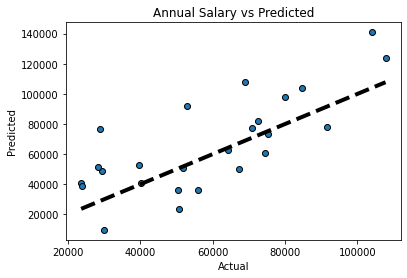

In [64]:

# Plot of predicted salary against actual salary
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Annual Salary vs Predicted")
plt.show()

### Desicion Tree

    

In [79]:
# Instantiate model
clf =  DecisionTreeRegressor(max_depth=5,random_state=0)

# Fit model
clf = clf.fit(x_train,y_train)

# Print the R-squared value for the model
clf.score(x_train, y_train)
    
y_predict_2 = clf.predict(x_test) 
        
y_predict_2

array([ 56979.        ,  96060.75      ,  57187.71428571,  57175.67307692,
        74803.2       ,  98617.5       , 105922.5       ,  48821.75      ,
        57175.67307692,  48821.75      ,  56979.        ,  74803.2       ,
        74511.        ,  56979.        ,  47691.21428571,  18993.        ,
        36038.        ,  27759.        ,  47691.21428571,  74803.2       ,
       115703.08333333,  57187.71428571,  60266.25      ,  56979.        ,
        79624.5       ])

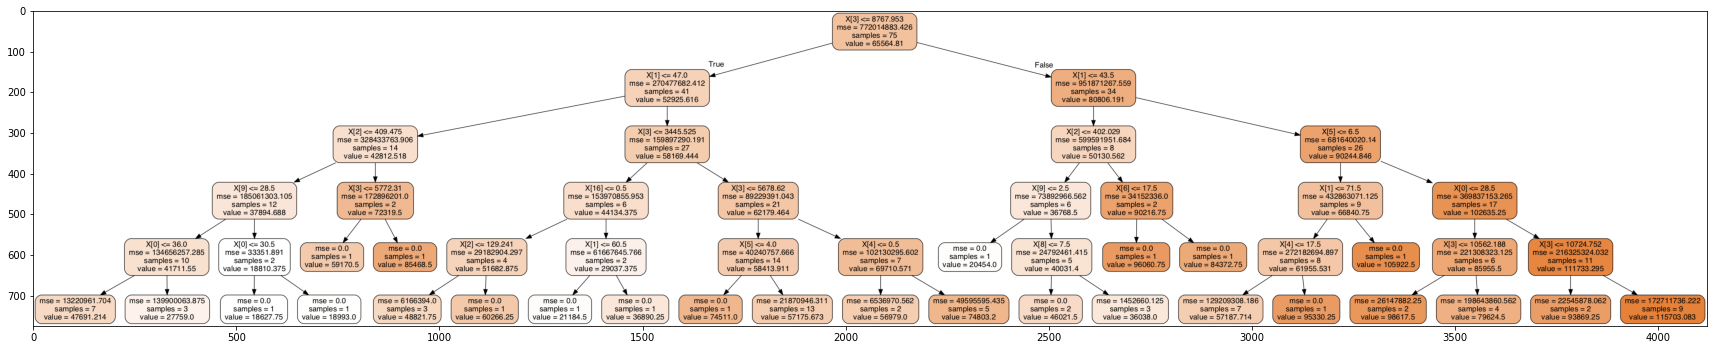

In [85]:
plt.figure(figsize = (30, 15))
dot_data=tree.export_graphviz(clf,filled=True,rounded=True)
graph=pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')    
plt.imshow(plt.imread('tree.png'));

In [80]:
# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_predict_2)))

27051.730726294394
